# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb

# Import Data

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df['Survived'] = df['Survived'].astype('int64')
df['PassengerId'] = df['PassengerId'].astype('category')
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

# Feature Selection

In [4]:
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']
target = 'Survived'

# Train Test Split

In [5]:
X = df[numerical_features + categorical_features]
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Outlier Removal

In [7]:
# only on the training set!!! But we won't use it on this dataset

# Numerical Transfomations

For the numerical columns we impute missing values with the mean and scale using the standar scaler method

In [8]:
numeric_transformer = Pipeline(steps=[
    ('mean_imputer', SimpleImputer(strategy='mean')),  # Impute with mean
    ('scaler', StandardScaler())  # Scale with StandardScaler
])

# Categorical Transformations

For the categorical columns we impute the missing values with the most frequent value and perform one hot enconding on the categorical columns

In [9]:
categorical_transformer = Pipeline(steps=[
    ('most_frequent_imputer', SimpleImputer(strategy='most_frequent')),  # Impute with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))  # One-Hot Encoding
])

# Preprocessing Pipeline

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_transformer', numeric_transformer, numerical_features),
        ('cat_transformer', categorical_transformer, categorical_features)
    ])

# Modeling Functions

In [11]:
def show_results(y_test, y_pred):    
    # 1. Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # 2. Classification Report (Precision, Recall, F1-Score, Support)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize Confusion Matrix using Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # 4. Precision, Recall, F1-Score (Bar Chart)
    # Extract precision, recall, and F1 scores from classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = report['1']  # Or you can use 'macro avg' or other types
    
    # Plot Precision, Recall, F1-Score
    metrics_data = {
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1-score']
    }
    
    # Create bar chart for the metrics
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(metrics_data.keys()), y=list(metrics_data.values()))
    plt.title("Precision, Recall, F1-Score")
    plt.ylabel("Score")
    plt.ylim(0, 1)  # Limit y-axis to 0-1
    plt.show()

In [12]:
def show_roc_curve(model, X, y):
    y_pred_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (area = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    print(f"The AUC for the Classifier is: {roc_auc:.4f}")

    # Calculate Youden's J statistic (TPR - FPR)
    j_scores = tpr - fpr
    
    # Find the index of the best threshold (maximum J score)
    best_threshold_index = np.argmax(j_scores)
    
    # The best threshold based on Youden's J
    best_threshold = thresholds[best_threshold_index]
    print(f"Best Threshold based on Youden's J statistic: {best_threshold}")

In [13]:
def show_cross_validation_stats(grid_search):     
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Print out the results of the grid search (train vs validation)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    # Display relevant columns for overfitting check
    # We look at mean_train_score and mean_test_score for each parameter combination
    print("Top 10 Hyperparameter Combinations and their Scores:")
    print(results.sort_values(by='rank_test_score')[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))

    # Check the training and validation scores across different hyperparameters
    train_scores = results['mean_train_score']
    valid_scores = results['mean_test_score']
    
    # Plot the training vs validation scores
    plt.figure(figsize=(8, 6))
    plt.plot(train_scores, label='Training Scores', color='blue', marker='o')
    plt.plot(valid_scores, label='Validation Scores', color='red', marker='x')
    plt.xlabel('Grid Search Iteration')
    plt.ylabel('Score (Accuracy)')
    plt.title('Training vs Validation Scores During GridSearchCV')
    plt.legend()
    plt.show()

In [14]:
def show_hyperparameter_training_stats(grid_search, parameter):
    results = pd.DataFrame(grid_search.cv_results_)
    
    if results[f'param_classifier__{parameter}'].dtype in ['float64', 'int64']:
        # If the parameter is numeric, sort by its numerical values
        results = results.sort_values(by=f'param_classifier__{parameter}')
    else:
        # If the parameter is categorical (string), sort alphabetically
        results = results.sort_values(by=f'param_classifier__{parameter}', key=lambda x: x.str.lower())

    # Visualize the performance for specific hyperparameters
    plt.figure(figsize=(12, 6))
    plt.errorbar(results[f'param_classifier__{parameter}'].astype(str), results['mean_train_score'], yerr=results['std_train_score'], label='Mean Train Score', capsize=4, fmt='o')
    plt.errorbar(results[f'param_classifier__{parameter}'].astype(str), results['mean_test_score'], yerr=results['std_test_score'], label='Mean Test Score (Validation)', capsize=4, fmt='o')
    plt.xlabel(parameter)
    plt.ylabel('Score (Accuracy)')
    plt.title(f'Training vs. Validation Score across {parameter}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def show_feature_importances(model):
    feature_importances = model.named_steps['classifier'].feature_importances_
    features_names = model.named_steps['preprocessor'].get_feature_names_out()
    
    importance_df = pd.DataFrame({
        'Feature': features_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(importance_df)
    
    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.tight_layout()

In [16]:
# Variable that stores the test scores of the different models to decide which one to use
report_ac = {}

# Modeling Parametrizations

In [17]:
metric_to_optimize = 'f1'

In [18]:
# we need to add the classifier__ to denote the parameter of the classifier in the pipeline
param_grid_nb = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # smoothing values to avoid division by zero
}

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],            # Inverse of regularization strength
    'classifier__penalty': ['l2'],                       # L2 regularization (common with 'lbfgs')
    'classifier__solver': ['lbfgs'],                     # Solver that supports L2
}

param_grid_dt = {
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

param_grid_svc = {
    'classifier__C': [0.01, 0.1, 0.5, 1],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],           # Number of trees
    'classifier__max_depth': [5, 10, 20],                 # Max depth of the tree
    'classifier__min_samples_split': [2, 5],              # Min samples to split an internal node
    'classifier__min_samples_leaf': [1, 2],               # Min samples at a leaf node
    'classifier__max_features': ['sqrt', 'log2'],         # Number of features to consider at each split
}

param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 10, 20],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
}

# Naive Bayes

In [19]:
nb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [20]:
grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid_nb,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [21]:
grid_search_nb.fit(X_train, y_train)

nb_model = grid_search_nb.best_estimator_

y_pred_nb = nb_model.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [22]:
accuracy = accuracy_score(y_test, y_pred_nb)
report = classification_report(y_test, y_pred_nb, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Naive Bayes'] = report

{'precision': 0.7454545454545455, 'recall': 0.5324675324675324, 'f1-score': 0.6212121212121212, 'support': 77.0, 'accuracy': 0.7206703910614525}


Accuracy: 0.7207

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       102
           1       0.75      0.53      0.62        77

    accuracy                           0.72       179
   macro avg       0.73      0.70      0.70       179
weighted avg       0.73      0.72      0.71       179



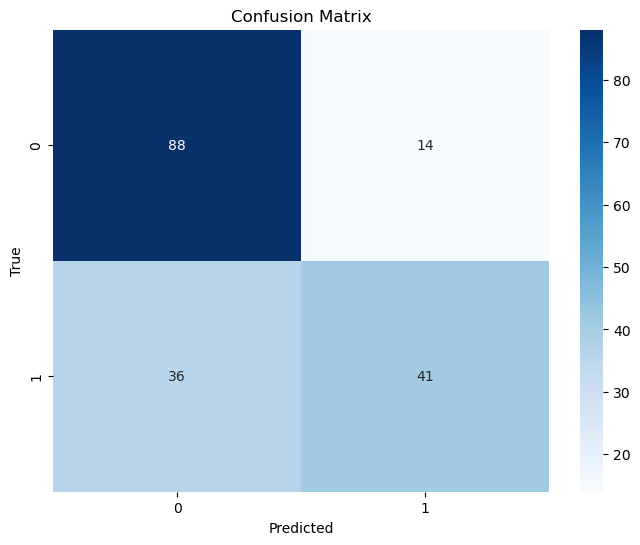

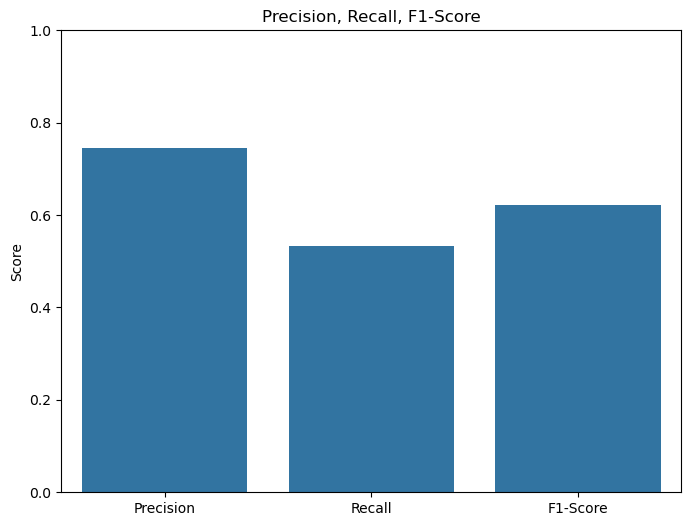

In [23]:
show_results(y_test, y_pred_nb)

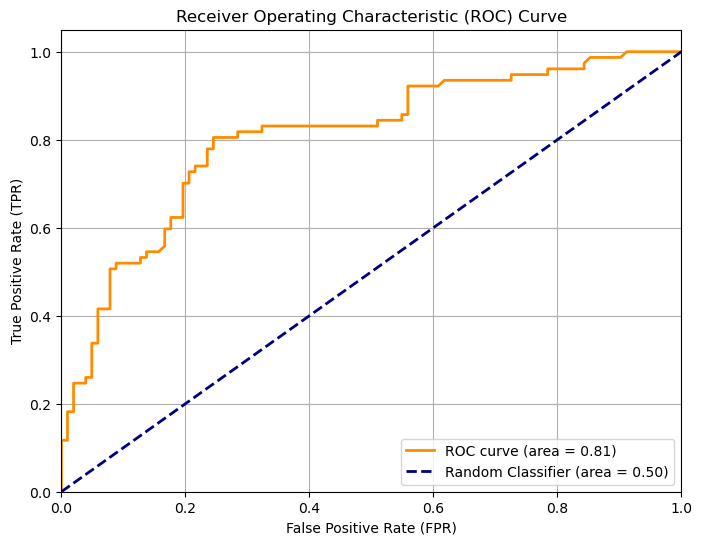

The AUC for the Classifier is: 0.8061
Best Threshold based on Youden's J statistic: 0.2721488089327912


In [24]:
show_roc_curve(nb_model, X_test, y_test)

Best parameters: {'classifier__var_smoothing': 1e-09}
Best cross-validation score: 0.6706775694161258
Top 10 Hyperparameter Combinations and their Scores:
                                 params  mean_train_score  std_train_score  \
0  {'classifier__var_smoothing': 1e-09}          0.672936         0.015588   
1  {'classifier__var_smoothing': 1e-08}          0.672936         0.015588   
2  {'classifier__var_smoothing': 1e-07}          0.672936         0.015588   
3  {'classifier__var_smoothing': 1e-06}          0.672936         0.015588   
4  {'classifier__var_smoothing': 1e-05}          0.672936         0.015588   

   mean_test_score  std_test_score  rank_test_score  
0         0.670678        0.031847                1  
1         0.670678        0.031847                1  
2         0.670678        0.031847                1  
3         0.670678        0.031847                1  
4         0.670678        0.031847                1  


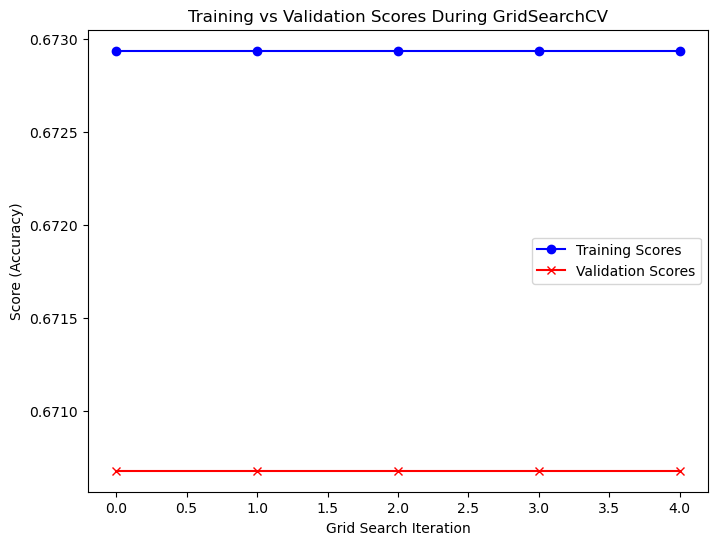

In [25]:
show_cross_validation_stats(grid_search_nb)

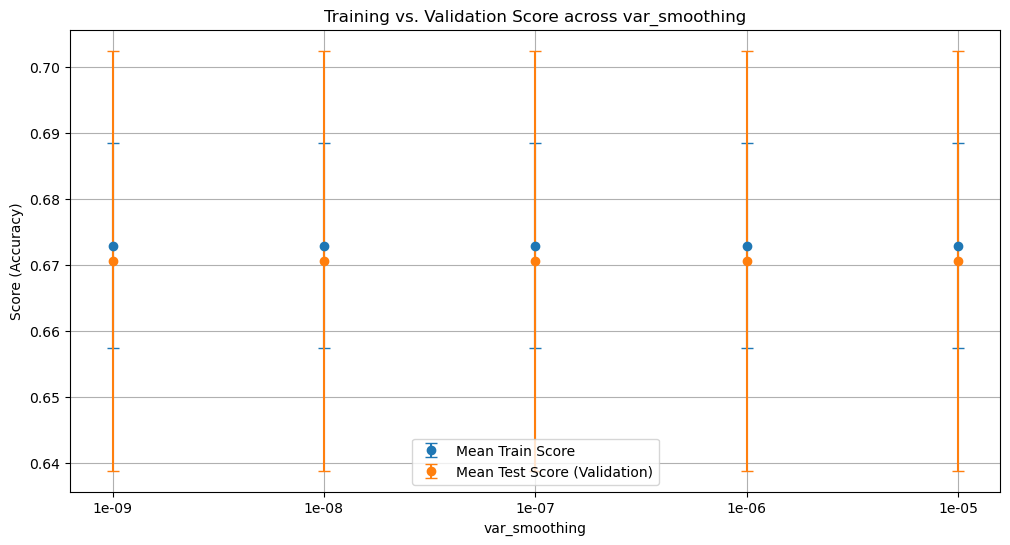

In [26]:
show_hyperparameter_training_stats(grid_search_nb, 'var_smoothing')

# Logistic Regression

In [27]:
lr_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [28]:
grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [29]:
grid_search_lr.fit(X_train, y_train)

lr_model = grid_search_lr.best_estimator_

y_pred_lr = lr_model.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [30]:
accuracy = accuracy_score(y_test, y_pred_lr)
report = classification_report(y_test, y_pred_lr, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Logistic Regression'] = report

{'precision': 0.8412698412698413, 'recall': 0.6883116883116883, 'f1-score': 0.7571428571428571, 'support': 77.0, 'accuracy': 0.8100558659217877}


Accuracy: 0.8101

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       102
           1       0.84      0.69      0.76        77

    accuracy                           0.81       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



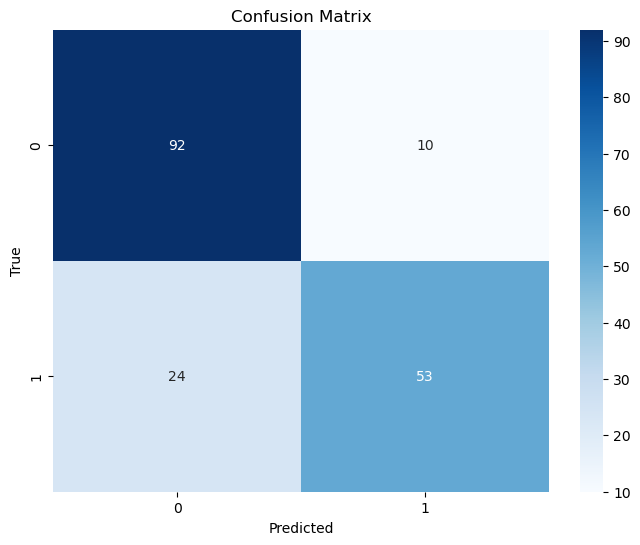

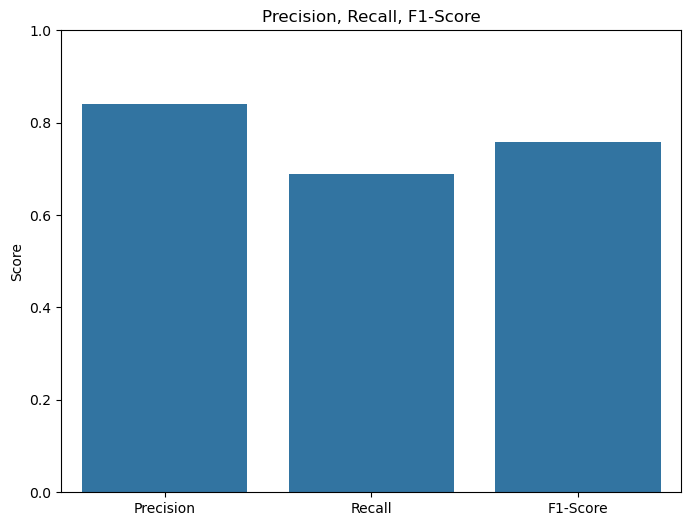

In [31]:
show_results(y_test, y_pred_lr)

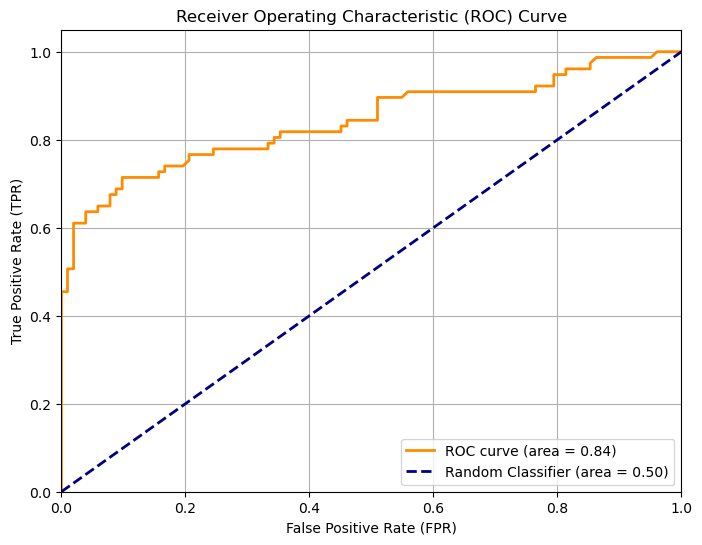

The AUC for the Classifier is: 0.8426
Best Threshold based on Youden's J statistic: 0.4549241642734068


In [32]:
show_roc_curve(lr_model, X_test, y_test)

Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation score: 0.7228978506873244
Top 10 Hyperparameter Combinations and their Scores:
                                              params  mean_train_score  \
2  {'classifier__C': 1, 'classifier__penalty': 'l...          0.733621   
1  {'classifier__C': 0.1, 'classifier__penalty': ...          0.723455   
3  {'classifier__C': 10, 'classifier__penalty': '...          0.732262   
4  {'classifier__C': 100, 'classifier__penalty': ...          0.731804   
0  {'classifier__C': 0.01, 'classifier__penalty':...          0.467355   

   std_train_score  mean_test_score  std_test_score  rank_test_score  
2         0.009739         0.722898        0.039438                1  
1         0.017116         0.722140        0.035637                2  
3         0.012007         0.721438        0.037909                3  
4         0.012380         0.721438        0.037909                3  
0

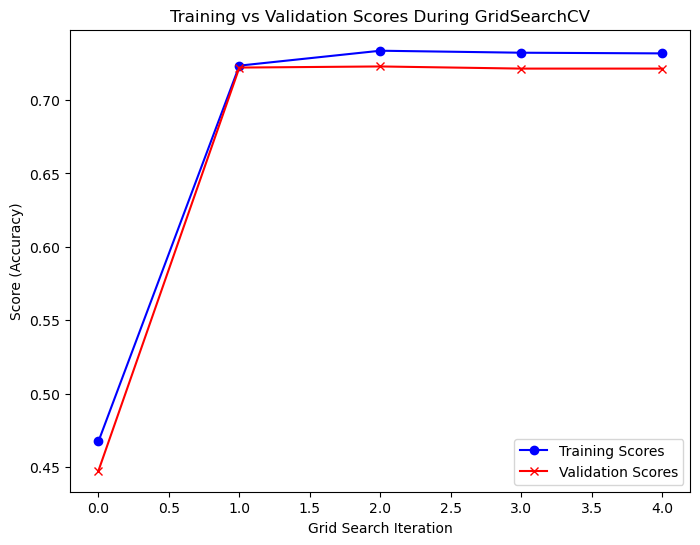

In [33]:
show_cross_validation_stats(grid_search_lr)

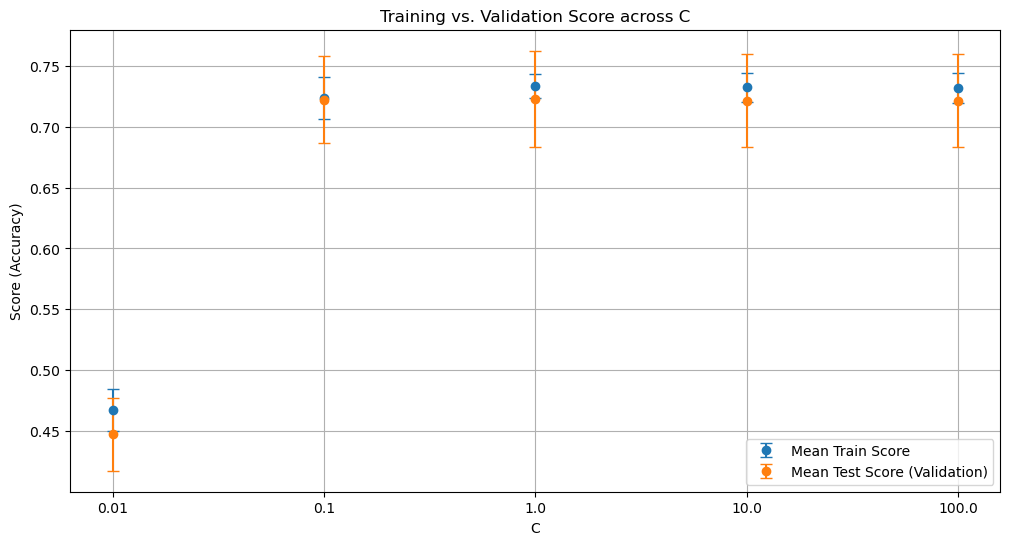

In [34]:
show_hyperparameter_training_stats(grid_search_lr, 'C')

# Decision Tree

In [35]:
dt_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [36]:
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=5,                
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,           
    verbose=1
)

In [37]:
grid_search_dt.fit(X_train, y_train)

dt_model = grid_search_dt.best_estimator_

y_pred_dt = dt_model.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [38]:
accuracy = accuracy_score(y_test, y_pred_dt)
report = classification_report(y_test, y_pred_dt, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Decision Tree'] = report

{'precision': 0.8225806451612904, 'recall': 0.6623376623376623, 'f1-score': 0.7338129496402878, 'support': 77.0, 'accuracy': 0.7932960893854749}


Accuracy: 0.7933

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       102
           1       0.82      0.66      0.73        77

    accuracy                           0.79       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.79      0.79       179



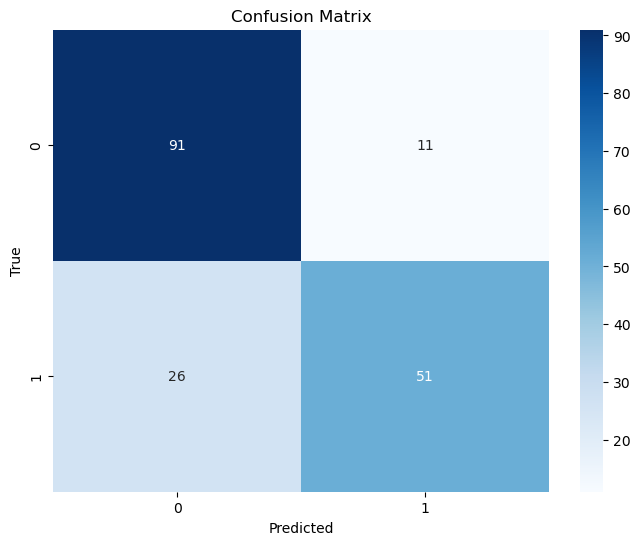

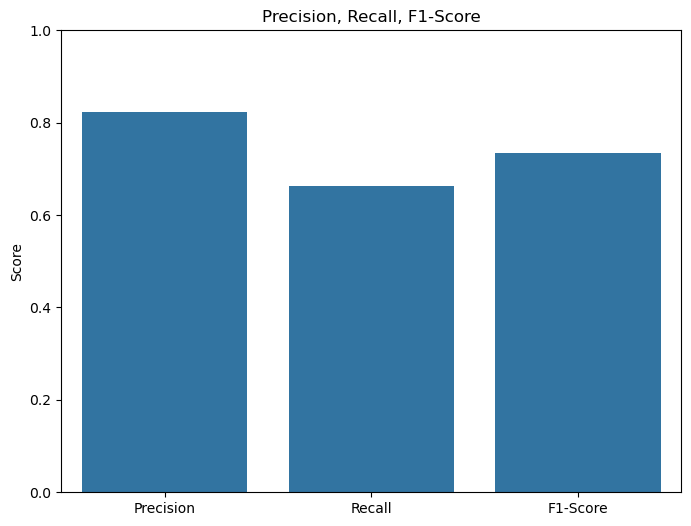

In [39]:
show_results(y_test, y_pred_dt)

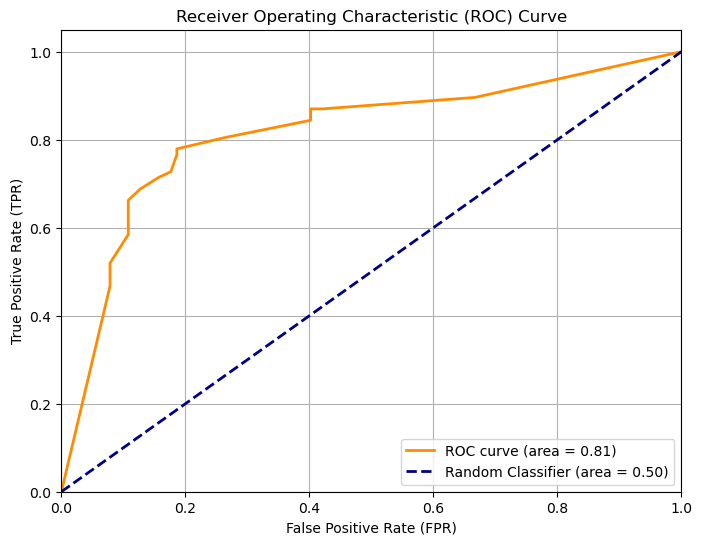

The AUC for the Classifier is: 0.8147
Best Threshold based on Youden's J statistic: 0.2857142857142857


In [40]:
show_roc_curve(dt_model, X_test, y_test)

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best cross-validation score: 0.7497975043176366
Top 10 Hyperparameter Combinations and their Scores:
                                               params  mean_train_score  \
11  {'classifier__criterion': 'gini', 'classifier_...          0.864603   
38  {'classifier__criterion': 'entropy', 'classifi...          0.858520   
20  {'classifier__criterion': 'gini', 'classifier_...          0.886718   
9   {'classifier__criterion': 'gini', 'classifier_...          0.918706   
10  {'classifier__criterion': 'gini', 'classifier_...          0.893732   
14  {'classifier__criterion': 'gini', 'classifier_...          0.853252   
47  {'classifier__criterion': 'entropy', 'classifi...          0.892726   
29  {'classifier__criterion': 'entropy', 'classifi...          0.772549   
2   {'classifier__criterion': 'gini', 'classifier_...          0.774548 

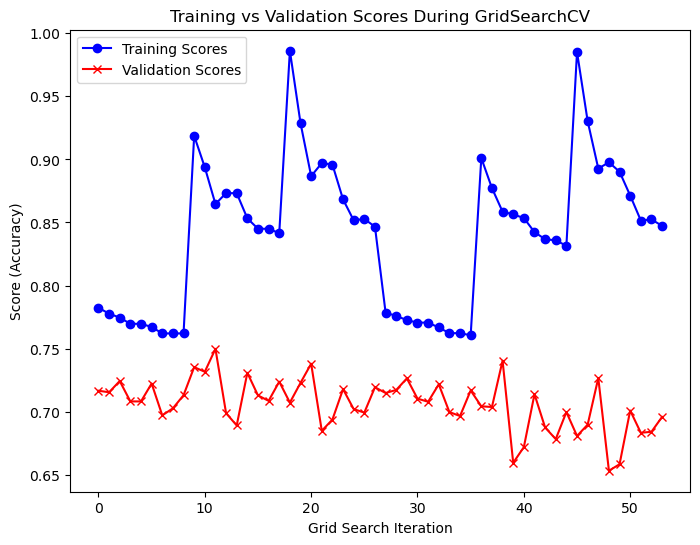

In [41]:
show_cross_validation_stats(grid_search_dt)

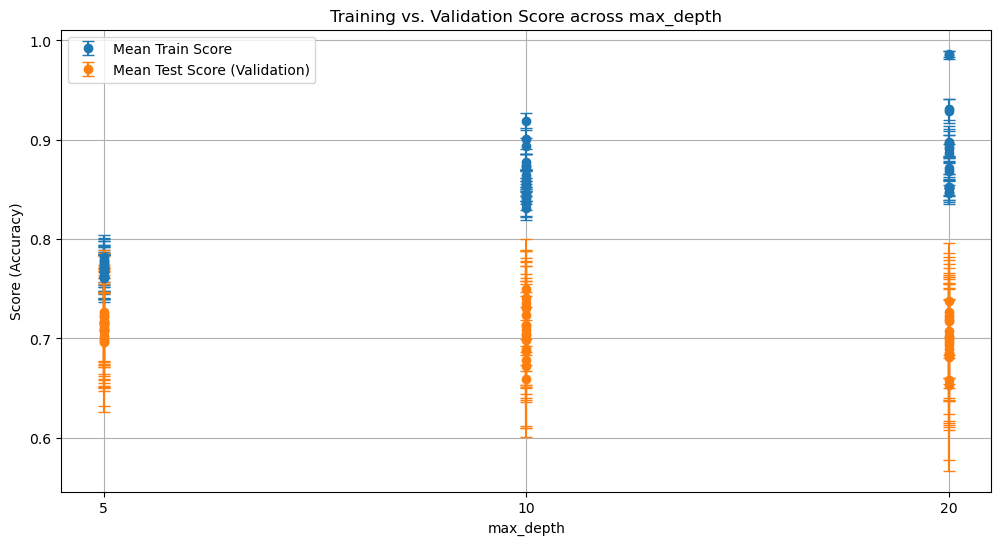

In [42]:
show_hyperparameter_training_stats(grid_search_dt, 'max_depth')

                        Feature  Importance
7     cat_transformer__Sex_male    0.400753
3         num_transformer__Fare    0.222377
0          num_transformer__Age    0.135120
6     cat_transformer__Pclass_3    0.117623
4     cat_transformer__Pclass_1    0.046400
1        num_transformer__SibSp    0.037689
2        num_transformer__Parch    0.025830
8   cat_transformer__Embarked_C    0.007466
10  cat_transformer__Embarked_S    0.006741
5     cat_transformer__Pclass_2    0.000000
9   cat_transformer__Embarked_Q    0.000000


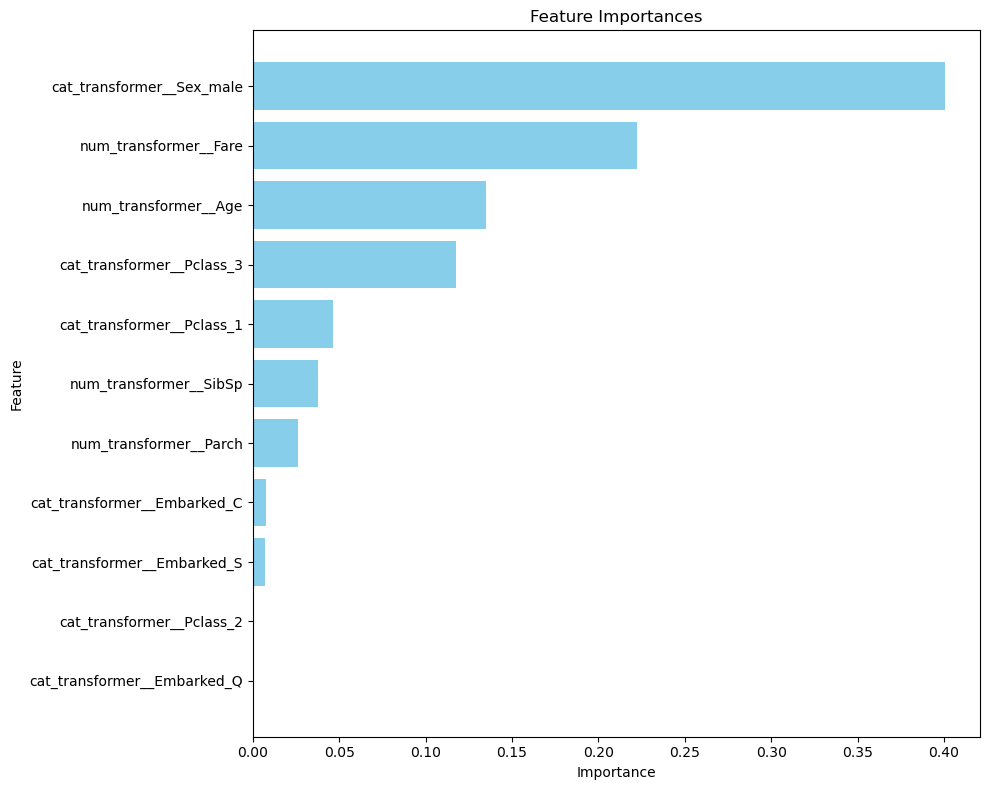

In [43]:
show_feature_importances(dt_model)

# Support Vector Machine

In [44]:
svc_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

In [45]:
grid_search_svc = GridSearchCV(
    estimator=svc_model,
    param_grid=param_grid_svc,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [46]:
grid_search_svc.fit(X_train, y_train)

svc_model = grid_search_svc.best_estimator_

y_pred_svc = svc_model.predict(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [47]:
accuracy = accuracy_score(y_test, y_pred_svc)
report = classification_report(y_test, y_pred_svc, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Support Vector Machine'] = report

{'precision': 0.8428571428571429, 'recall': 0.7662337662337663, 'f1-score': 0.8027210884353742, 'support': 77.0, 'accuracy': 0.8379888268156425}


Accuracy: 0.8380

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       102
           1       0.84      0.77      0.80        77

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



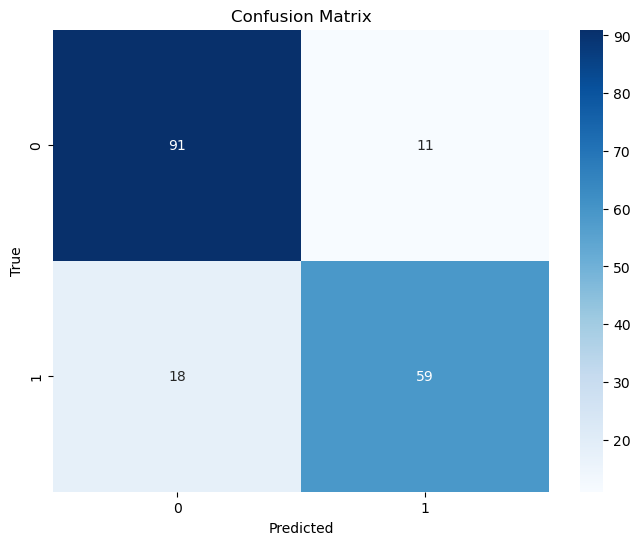

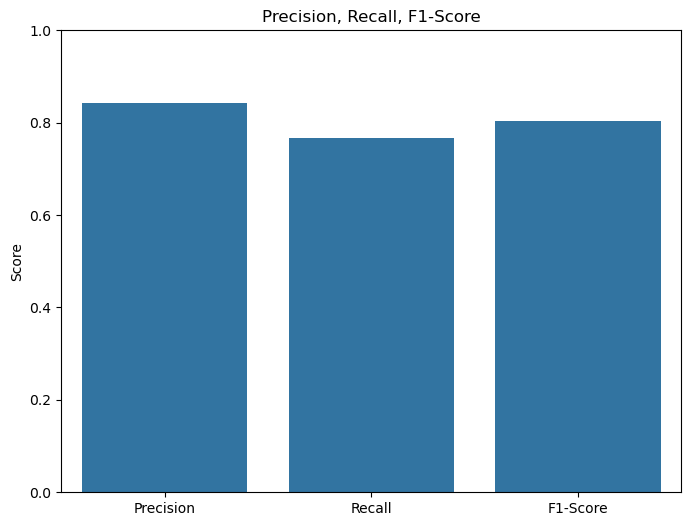

In [48]:
show_results(y_test, y_pred_svc)

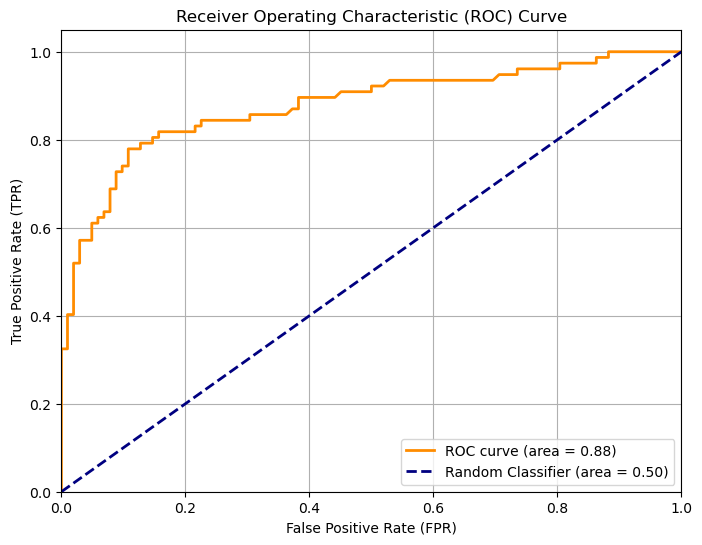

The AUC for the Classifier is: 0.8780
Best Threshold based on Youden's J statistic: 0.43318539988117716


In [49]:
show_roc_curve(svc_model, X_test, y_test)

Best parameters: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.7302062035990833
Top 10 Hyperparameter Combinations and their Scores:
                                               params  mean_train_score  \
36  {'classifier__C': 1, 'classifier__gamma': 0.1,...          0.754582   
32  {'classifier__C': 1, 'classifier__gamma': 'aut...          0.752690   
30  {'classifier__C': 1, 'classifier__gamma': 'sca...          0.762026   
20  {'classifier__C': 0.5, 'classifier__gamma': 's...          0.755703   
38  {'classifier__C': 1, 'classifier__gamma': 1, '...          0.831051   
22  {'classifier__C': 0.5, 'classifier__gamma': 'a...          0.745683   
26  {'classifier__C': 0.5, 'classifier__gamma': 0....          0.748307   
34  {'classifier__C': 1, 'classifier__gamma': 0.01...          0.711582   
28  {'classifier__C': 0.5, 'classifier__gamma': 1,...          0.818921   
37  {'classifier__C': 1, 'classifier__gamma': 0.1,...   

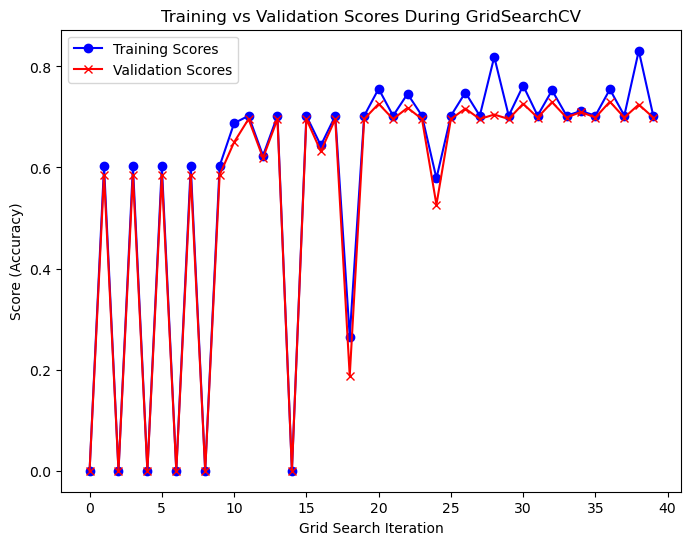

In [50]:
show_cross_validation_stats(grid_search_svc)

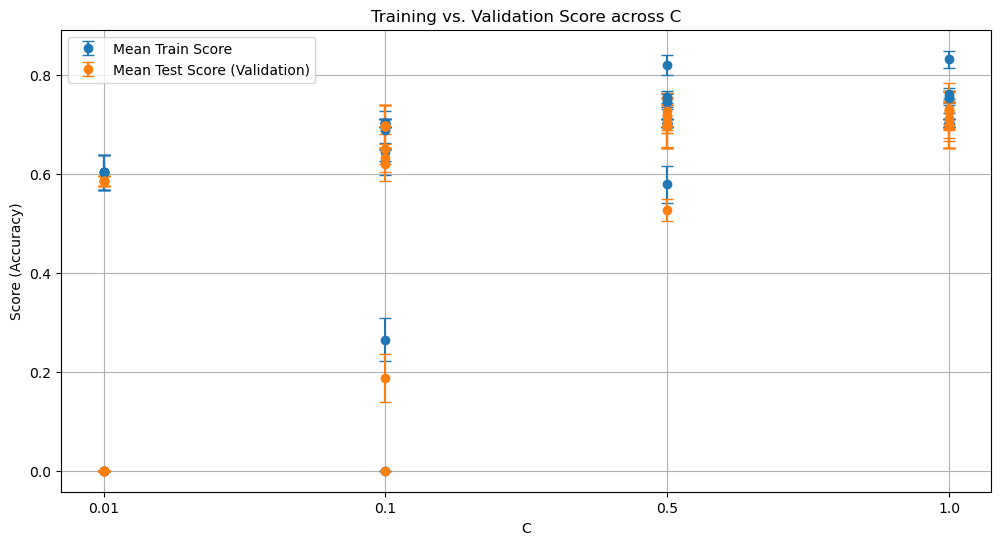

In [51]:
show_hyperparameter_training_stats(grid_search_svc, 'C')

# Random Forest

In [52]:
rf_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [53]:
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [54]:
grid_search_rf.fit(X_train, y_train)

rf_model = grid_search_rf.best_estimator_

y_pred_rf = rf_model.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [55]:
accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Random Forest'] = report

{'precision': 0.8571428571428571, 'recall': 0.7012987012987013, 'f1-score': 0.7714285714285715, 'support': 77.0, 'accuracy': 0.8212290502793296}


Accuracy: 0.8212

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       102
           1       0.86      0.70      0.77        77

    accuracy                           0.82       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.82      0.82       179



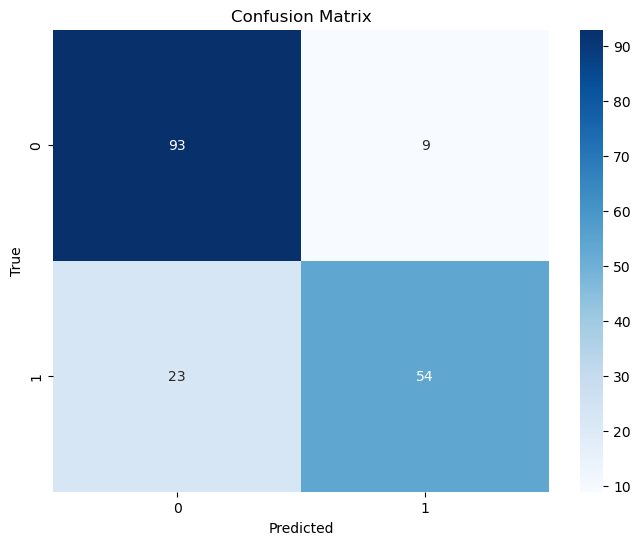

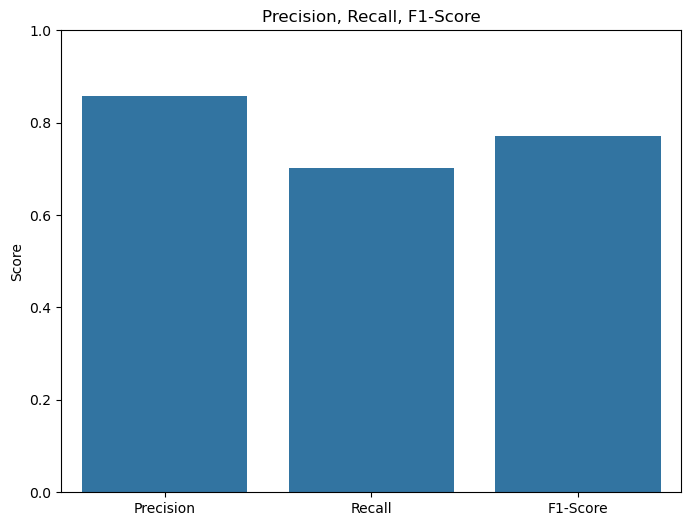

In [56]:
show_results(y_test, y_pred_rf)

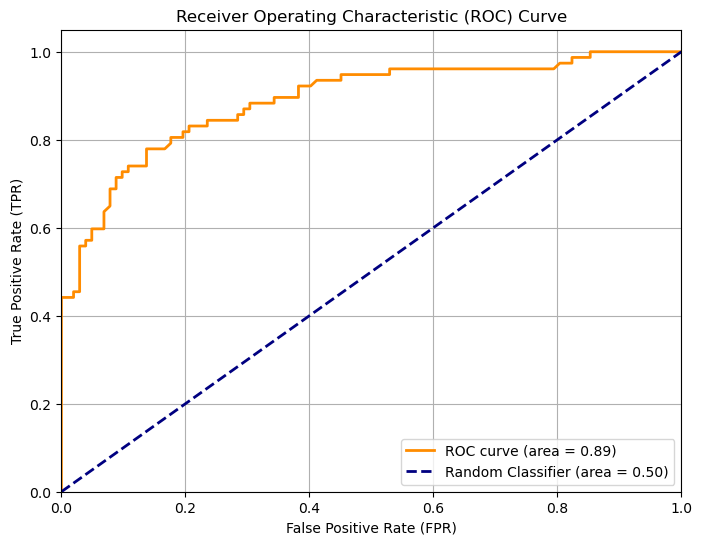

The AUC for the Classifier is: 0.8891
Best Threshold based on Youden's J statistic: 0.3712806344682133


In [57]:
show_roc_curve(rf_model, X_test, y_test)

Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.7612949179671868
Top 10 Hyperparameter Combinations and their Scores:
                                               params  mean_train_score  \
68  {'classifier__max_depth': 20, 'classifier__max...          0.880675   
28  {'classifier__max_depth': 10, 'classifier__max...          0.899609   
65  {'classifier__max_depth': 20, 'classifier__max...          0.909958   
29  {'classifier__max_depth': 10, 'classifier__max...          0.896167   
37  {'classifier__max_depth': 10, 'classifier__max...          0.939499   
52  {'classifier__max_depth': 20, 'classifier__max...          0.916042   
45  {'classifier__max_depth': 10, 'classifier__max...          0.869781   
41  {'classifier__max_depth': 10, 'classifier__max...          0.898496   
35  {'classifier__max_depth': 10, 'cl

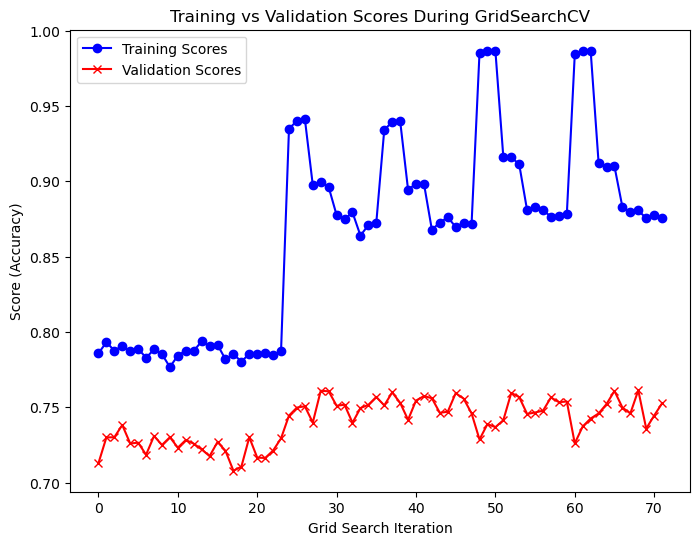

In [58]:
show_cross_validation_stats(grid_search_rf)

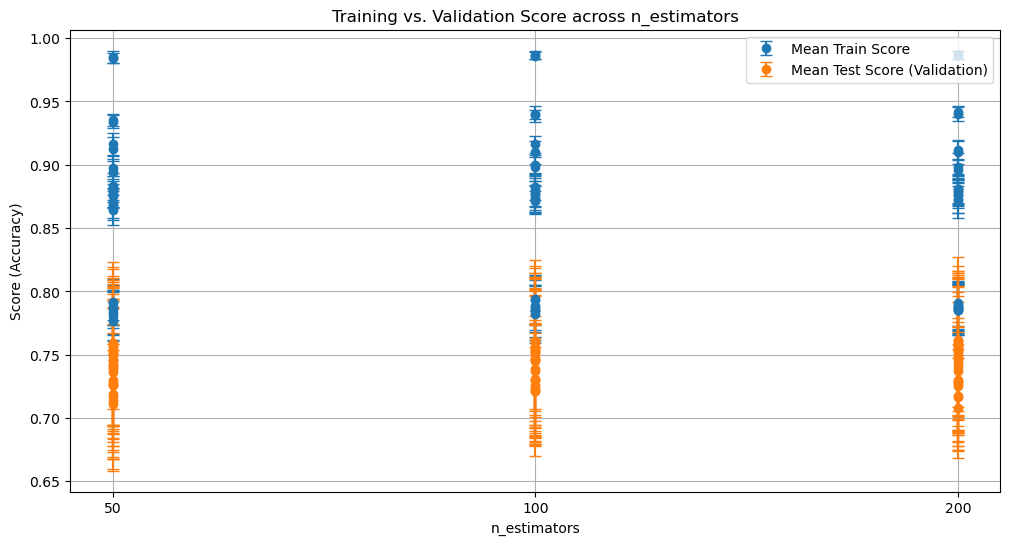

In [59]:
show_hyperparameter_training_stats(grid_search_rf, 'n_estimators')

                        Feature  Importance
7     cat_transformer__Sex_male    0.303527
3         num_transformer__Fare    0.233659
0          num_transformer__Age    0.192662
6     cat_transformer__Pclass_3    0.090732
1        num_transformer__SibSp    0.042418
4     cat_transformer__Pclass_1    0.037993
2        num_transformer__Parch    0.037444
5     cat_transformer__Pclass_2    0.020220
8   cat_transformer__Embarked_C    0.018610
10  cat_transformer__Embarked_S    0.015521
9   cat_transformer__Embarked_Q    0.007214


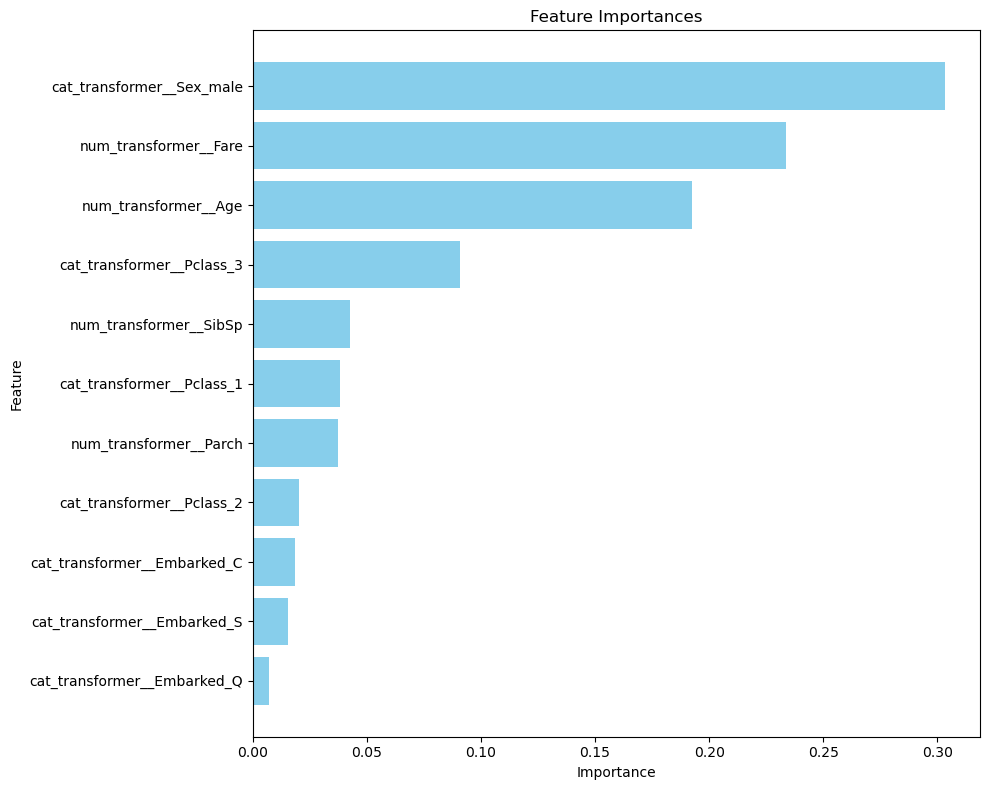

In [60]:
show_feature_importances(rf_model)

# XGBoost

In [61]:
xgb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic',eval_metric='mlogloss'))
])

In [62]:
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [63]:
grid_search_xgb.fit(X_train, y_train)

xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = xgb_model.predict(X_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [64]:
accuracy = accuracy_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['XGBoost'] = report

{'precision': 0.8412698412698413, 'recall': 0.6883116883116883, 'f1-score': 0.7571428571428571, 'support': 77.0, 'accuracy': 0.8100558659217877}


Accuracy: 0.8101

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       102
           1       0.84      0.69      0.76        77

    accuracy                           0.81       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



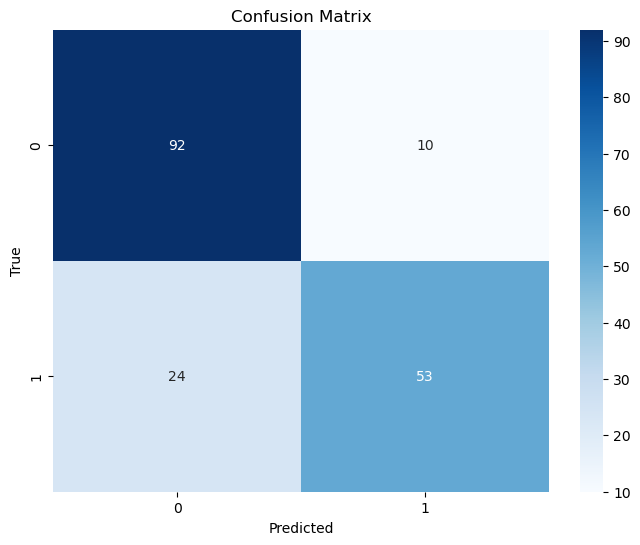

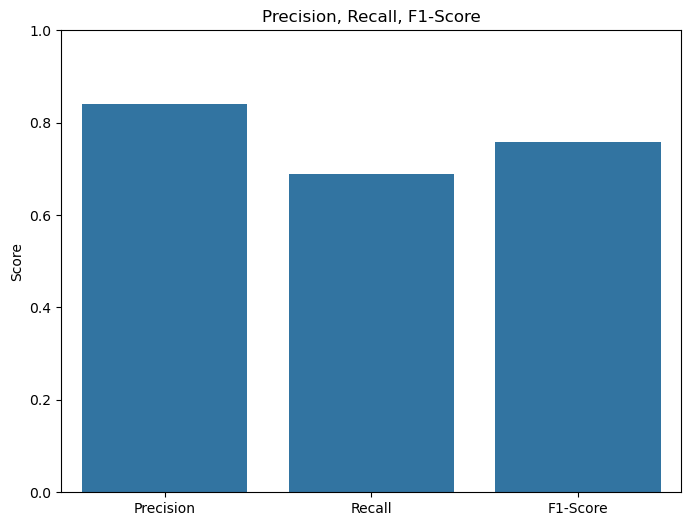

In [65]:
show_results(y_test, y_pred_xgb)

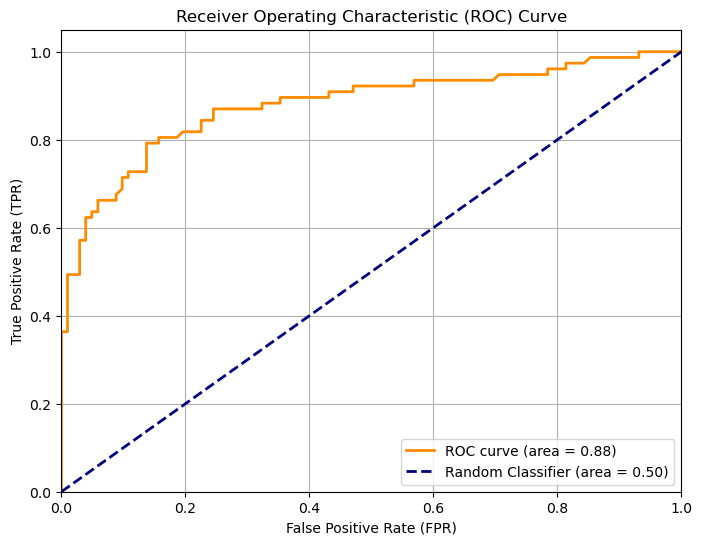

The AUC for the Classifier is: 0.8794
Best Threshold based on Youden's J statistic: 0.3643593490123749


In [66]:
show_roc_curve(xgb_model, X_test, y_test)

Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Best cross-validation score: 0.7752717539795216
Top 10 Hyperparameter Combinations and their Scores:
                                                params  mean_train_score  \
30   {'classifier__colsample_bytree': 0.8, 'classif...          0.876445   
36   {'classifier__colsample_bytree': 0.8, 'classif...          0.901077   
103  {'classifier__colsample_bytree': 1.0, 'classif...          0.883757   
88   {'classifier__colsample_bytree': 1.0, 'classif...          0.866874   
94   {'classifier__colsample_bytree': 1.0, 'classif...          0.867446   
11   {'classifier__colsample_bytree': 0.8, 'classif...          0.843262   
82   {'classifier__colsample_bytree': 1.0, 'classif...          0.842457   
109  {'classifier__colsample_bytree': 1.0, 'classif...          0.910103   
66   {'classifier__colsample_bytree'

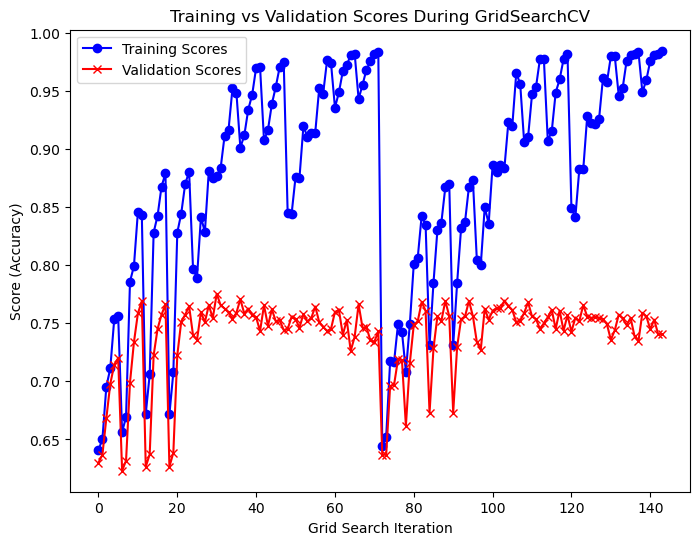

In [67]:
show_cross_validation_stats(grid_search_xgb)

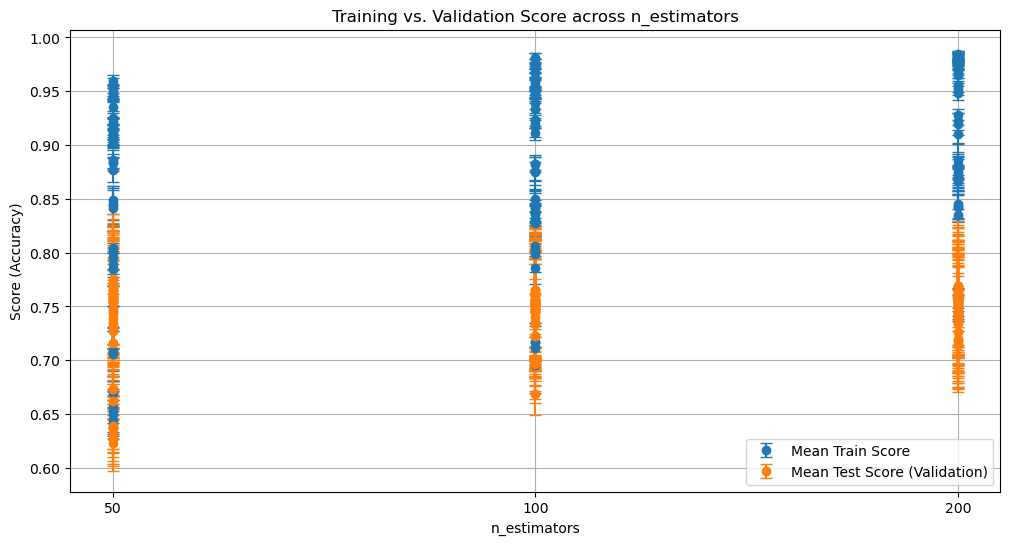

In [68]:
show_hyperparameter_training_stats(grid_search_xgb, 'n_estimators')

                        Feature  Importance
7     cat_transformer__Sex_male    0.483030
6     cat_transformer__Pclass_3    0.170536
4     cat_transformer__Pclass_1    0.084470
1        num_transformer__SibSp    0.042602
10  cat_transformer__Embarked_S    0.037741
3         num_transformer__Fare    0.034629
0          num_transformer__Age    0.033341
2        num_transformer__Parch    0.030667
5     cat_transformer__Pclass_2    0.030587
8   cat_transformer__Embarked_C    0.027545
9   cat_transformer__Embarked_Q    0.024851


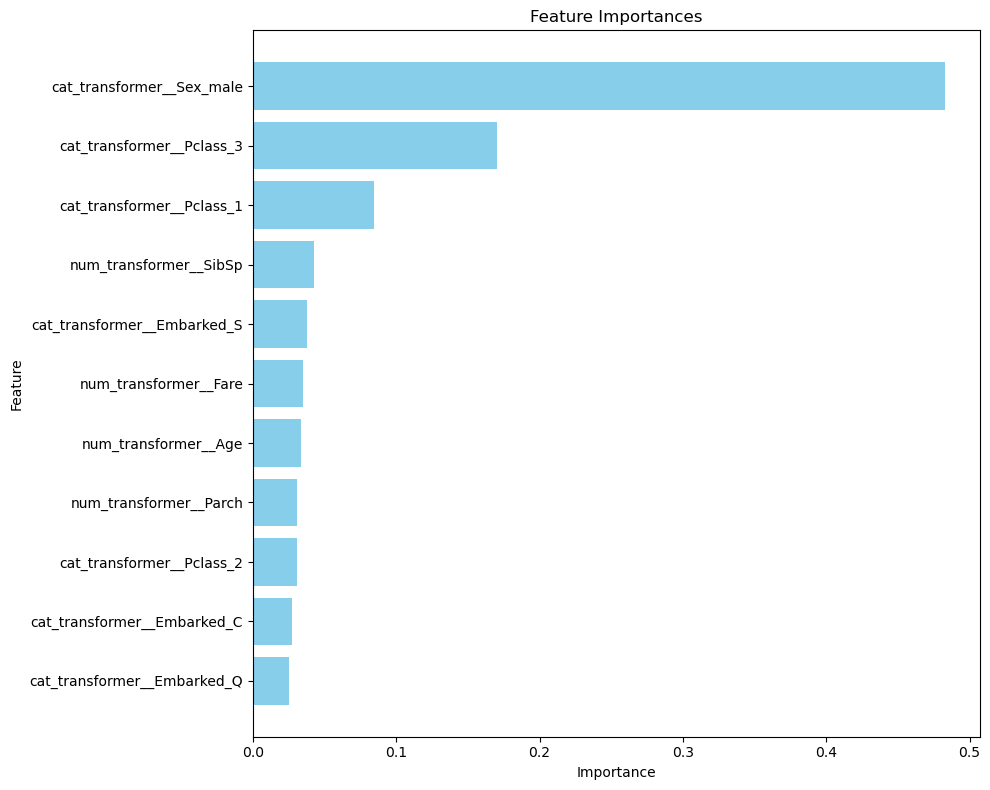

In [69]:
show_feature_importances(xgb_model)

# Model Evaluation

In [70]:
report_ac

{'Naive Bayes': {'precision': 0.7454545454545455,
  'recall': 0.5324675324675324,
  'f1-score': 0.6212121212121212,
  'support': 77.0,
  'accuracy': 0.7206703910614525},
 'Logistic Regression': {'precision': 0.8412698412698413,
  'recall': 0.6883116883116883,
  'f1-score': 0.7571428571428571,
  'support': 77.0,
  'accuracy': 0.8100558659217877},
 'Decision Tree': {'precision': 0.8225806451612904,
  'recall': 0.6623376623376623,
  'f1-score': 0.7338129496402878,
  'support': 77.0,
  'accuracy': 0.7932960893854749},
 'Support Vector Machine': {'precision': 0.8428571428571429,
  'recall': 0.7662337662337663,
  'f1-score': 0.8027210884353742,
  'support': 77.0,
  'accuracy': 0.8379888268156425},
 'Random Forest': {'precision': 0.8571428571428571,
  'recall': 0.7012987012987013,
  'f1-score': 0.7714285714285715,
  'support': 77.0,
  'accuracy': 0.8212290502793296},
 'XGBoost': {'precision': 0.8412698412698413,
  'recall': 0.6883116883116883,
  'f1-score': 0.7571428571428571,
  'support': 77

# Running against the real test

In [71]:
# best model
rf_model

df = pd.read_csv('tested.csv')

df['PassengerId'] = df['PassengerId'].astype('category')
df['Survived'] = df['Survived'].astype('int64')
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']
target = 'Survived'

X = df[numerical_features + categorical_features].copy()
y = df[target].copy()

In [72]:
y_pred_rf_test = rf_model.predict(X)

In [73]:
accuracy = accuracy_score(y, y_pred_rf_test)
report = classification_report(y, y_pred_rf_test, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

{'precision': 0.8321678321678322, 'recall': 0.7828947368421053, 'f1-score': 0.8067796610169492, 'support': 152.0, 'accuracy': 0.8636363636363636}


<Axes: >

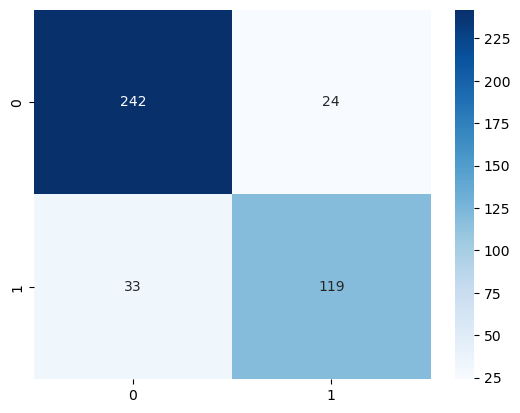

In [74]:
cm = confusion_matrix(y, y_pred_rf_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')